In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import pandas as pd
import numpy as np

In [2]:
results_dirs = {
    "mtsNFVS": "../benchmark/results-nfvs/",
    "AEON.py": "../benchmark/results-aeon/",
    "biobalm": "../benchmark/results-0.2.0/",
}

nk3_fnames = {  # will make others when they are ready
    "all": "random-nk3.csv",
    "biobalm-expand": "random-nk3-full-expand.csv",
    "biobalm-search": "random-nk3-full-attractors.csv",
}

colors = {
    "mtsNFVS": "#DDAA33",
    "AEON.py": "#BB5566",
    "biobalm": "#004488",
}

In [3]:
df_test = pd.read_csv(
    results_dirs["AEON.py"] + nk3_fnames["all"],
    header=None,
    skiprows=1,
    names=["Benchmark", "Time[s]", "Notes"],
)
df_test["Time[s]"]

n10_0       2
n10_1       5
n10_10      1
n10_100     2
n10_101     5
           ..
n80_95      2
n80_96      4
n80_97      2
n80_98      3
n80_99      1
Name: Time[s], Length: 2100, dtype: object

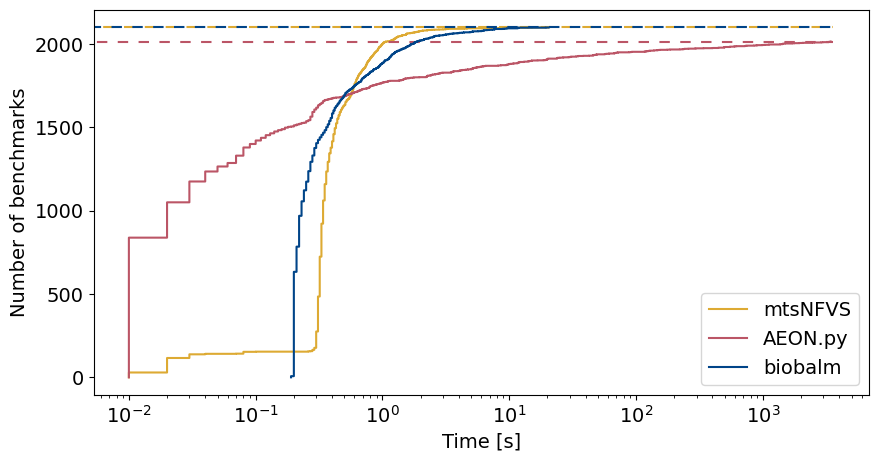

In [4]:
def plot_cumulative(dirs, fnames, colors):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.set_facecolor("white")

    for i, (tool, dir) in enumerate(dirs.items()):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            )
            t = df["Time[s]"].sort_values()
        elif tool == "AEON.py":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "v1", "v2"],
            )
            df["Time[s]"] = df["Time[s]"].apply(
                lambda x: float("inf") if x == " FAIL" else float(x)
            )
            t = df["Time[s]"].sort_values()
        elif tool == "biobalm":
            df_exp = pd.read_csv(
                dirs[tool] + fnames["biobalm-expand"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "_1", "_2", "_3"],
            )
            df_att = pd.read_csv(
                dirs[tool] + fnames["biobalm-search"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "_1", "_2", "_3", "_4"],
            )

            t = (df_exp["Time[s]"] + df_att["Time[s]"]).sort_values()
        else:
            print(f"SKIPPING {tool}")
            continue
        successes = sum(t < float("inf"))
        ax.hlines(
            y=successes,
            xmin=0,
            xmax=3600,
            color=colors[tool],
            linestyle=(i * 3, (5, 5)),
        )
        ax.step(t, np.arange(len(t)), label=tool, c=colors[tool])

    ax.set_xscale("log")

    ax.set_xlabel("Time [s]", fontsize=14)
    ax.set_ylabel("Number of benchmarks", fontsize=14)

    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14, loc="lower right")


plot_cumulative(results_dirs, nk3_fnames, colors)

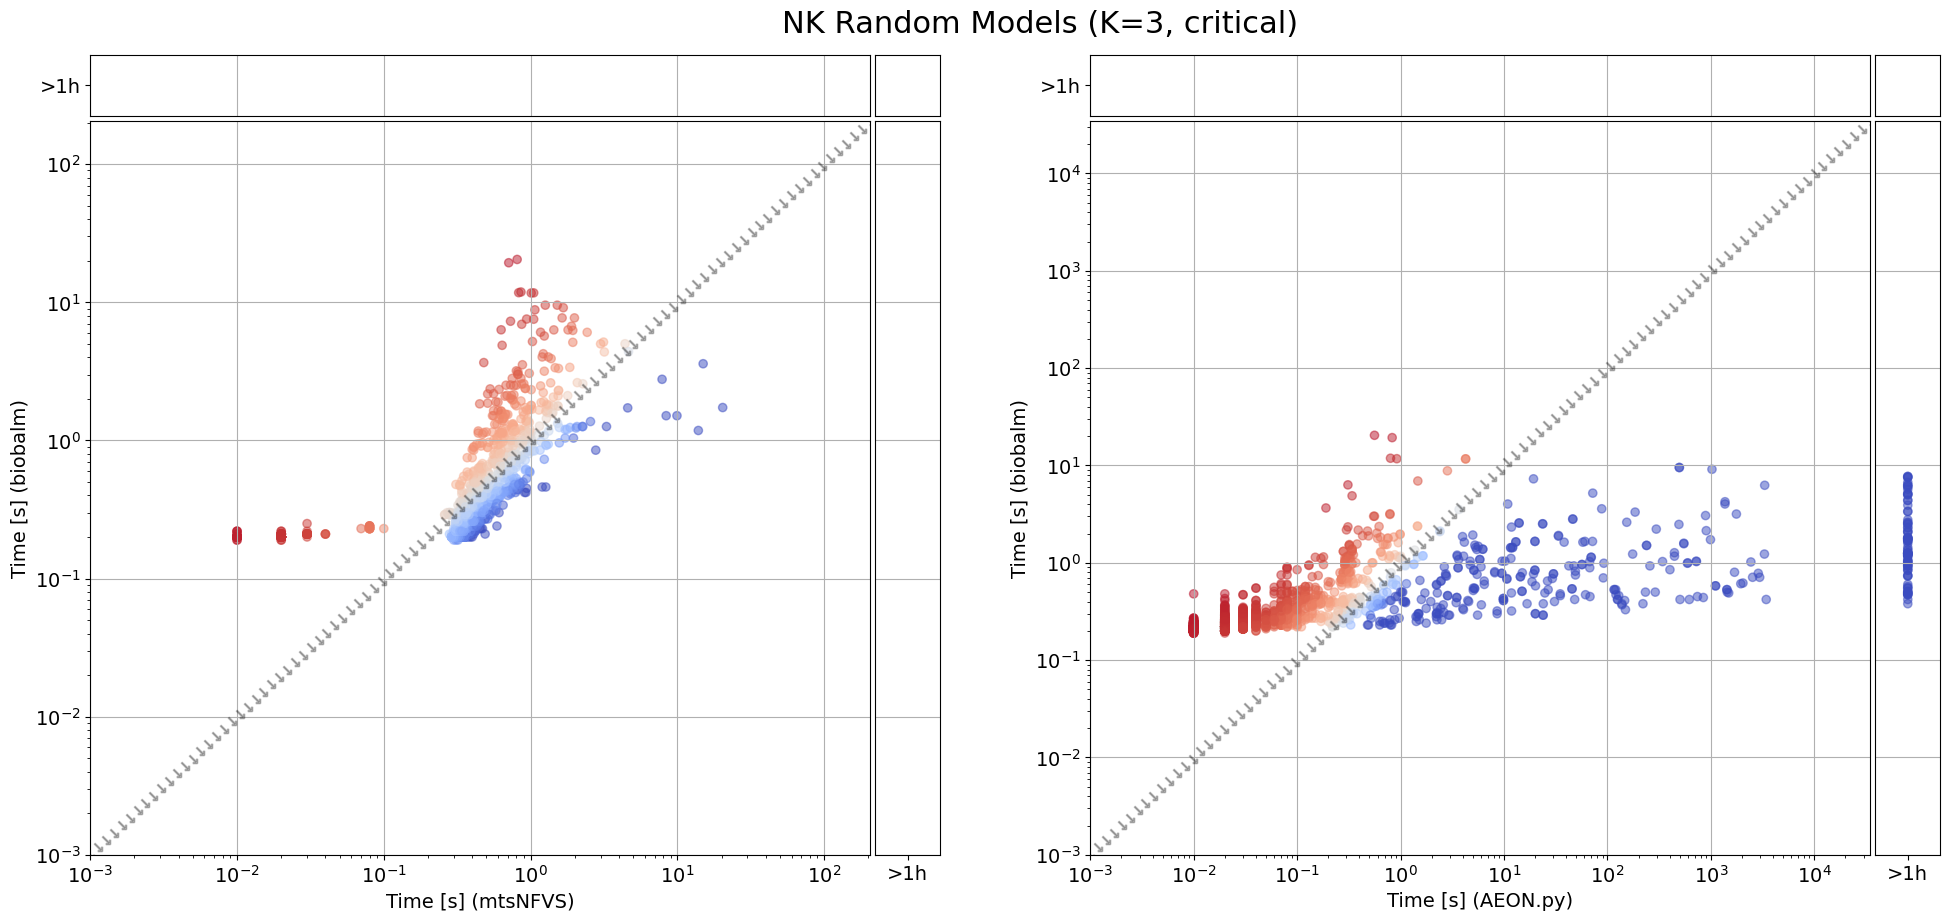

In [22]:
def plot_scatter(dirs, fnames, title=""):
    stretch_factor = 12
    fig = plt.figure(figsize=(20, 10))

    fig.set_facecolor("white")
    figs = fig.subfigures(1, 2)
    for afig, tool in zip(figs.flatten(), ["mtsNFVS", "AEON.py"]):
        if tool == "mtsNFVS":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "Notes"],
            )
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        elif tool == "AEON.py":
            df = pd.read_csv(
                dirs[tool] + fnames["all"],
                header=None,
                skiprows=1,
                names=["Benchmark", "Time[s]", "v1", "v2"],
            )
            df["Time[s]"] = df["Time[s]"].apply(
                lambda x: float("inf") if x == " FAIL" else float(x)
            )
            df.sort_values(by="Benchmark", inplace=True)
            t = df["Time[s]"]
        else:
            continue
        df_exp = pd.read_csv(
            dirs["biobalm"] + fnames["biobalm-expand"],
            header=None,
            skiprows=1,
            names=["Benchmark", "Time[s]", "_1", "_2", "_3"],
        )
        df_exp.sort_values(by="Benchmark", inplace=True)
        df_att = pd.read_csv(
            dirs["biobalm"] + fnames["biobalm-search"],
            header=None,
            skiprows=1,
            names=["Benchmark", "Time[s]", "_1", "_2", "_3", "_4"],
        )
        df_att.sort_values(by="Benchmark", inplace=True)
        t_bb = df_exp["Time[s]"] + df_att["Time[s]"]

        axd = afig.subplot_mosaic(
            [
                ["BBTimeout", "BothTimeout"],
                ["BothRan", "CompTimeout"],
            ],
            gridspec_kw={
                "width_ratios": [stretch_factor, 1],
                "height_ratios": [1, stretch_factor],
            },
        )

        axd["BothRan"].scatter(
            t,
            t_bb,
            c=t / t_bb,
            alpha=0.5,
            norm=CenteredNorm(vcenter=1, halfrange=1),
            cmap="coolwarm_r",
        )

        tmax = max(t[t < float("inf")].max(), t_bb[t_bb < float("inf")].max()) * 10.0
        tmin = min(t[t < float("inf")].min(), t_bb[t_bb < float("inf")].min()) / 10.0
        axd["BothRan"].set_xlim(tmin, tmax)
        axd["BothRan"].set_ylim(tmin, tmax)
        axd["BothRan"].set_xscale("log")
        axd["BothRan"].set_yscale("log")

        axd["BothRan"].set_xlabel(f"Time [s] ({tool})", fontsize=14)
        axd["BothRan"].set_ylabel("Time [s] (biobalm)", fontsize=14)
        axd["BothRan"].tick_params(labelsize=14, gridOn=True)

        boundary_pts = np.logspace(np.log10(tmin), np.log10(tmax), 100)
        axd["BothRan"].plot(
            boundary_pts,
            boundary_pts,
            color="black",
            linestyle="",
            marker=r"$\searrow$",
            alpha=0.25,
        )

        axd["BBTimeout"].scatter(
            t[t_bb == float("inf")],
            0 * t[t_bb == float("inf")],
            norm=CenteredNorm(vcenter=1, halfrange=0.5),
            c=0 * t[t_bb == float("inf")],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["BBTimeout"].sharex(axd["BothRan"])
        axd["BBTimeout"].set_xscale("log")
        axd["BBTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )
        axd["BBTimeout"].tick_params(axis="x", gridOn=True)
        axd["BBTimeout"].tick_params(axis="y", tick1On=True, labelleft=True)
        axd["BBTimeout"].set_yticks([0])
        axd["BBTimeout"].set_yticklabels([">1h"], fontsize=14)

        axd["CompTimeout"].scatter(
            0 * t_bb[t == float("inf")],
            t_bb[t == float("inf")],
            norm=CenteredNorm(vcenter=-1, halfrange=0.5),
            c=0 * t_bb[t == float("inf")],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["CompTimeout"].sharey(axd["BothRan"])
        axd["CompTimeout"].set_yscale("log")
        axd["CompTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )
        axd["CompTimeout"].tick_params(axis="y", gridOn=True)
        axd["CompTimeout"].tick_params(axis="x", tick1On=True, labelbottom=True)
        axd["CompTimeout"].set_xticks([0])
        axd["CompTimeout"].set_xticklabels([">1h"], fontsize=14)

        axd["BothTimeout"].scatter(
            0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            norm=CenteredNorm(vcenter=0, halfrange=0.5),
            c=0 * t_bb[(t == float("inf")) & (t_bb == float("inf"))],
            cmap="coolwarm_r",
            alpha=0.5,
        )
        axd["BothTimeout"].tick_params(
            which="both",
            labelbottom=False,
            labelleft=False,
            tick1On=False,
            tick2On=False,
        )

        afig.subplots_adjust(hspace=0.0135, wspace=0.0135)

    fig.subplots_adjust(bottom=0.08, left=0.05)
    fig.suptitle(title, fontsize=22, y=0.925)


plot_scatter(results_dirs, nk3_fnames, title="NK Random Models (K=3, critical)")